# Problem Description

This project involves parsing a dataset of tweets from X (formerly known as Twitter) to classify if they are referring to a disaster/emergency or not. Natural language is tricky and tweets can be hyperbolic to the point where the language would make it seem like it's talking about an emergency when it's clearly sarcastic. By classifying these tweets, it could help to quickly identify when an actual emergency is happening. The project's description states that agencies have or hope to have these kinds of systems in place to help respond to emergencies. Since tweets are in natural language, these require different processing of data compared to numeric features.

In [19]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import string
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Flatten, GlobalMaxPool1D, GRU
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
import subprocess
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

# https://stackoverflow.com/a/76079671 - fix for importing wordnet
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

# Set train and test directories, and set 
train_csv = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_csv = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


# Exploratory Data Analysis

In [20]:
# View columns, rows and data types
print(train_csv.info())

#View the first 5 rows of the data
print(train_csv.head())

# View the stats of each column
print(train_csv.describe())

# View some columns with at least one of keyword or location column having a value
print(train_csv[train_csv['keyword'].notnull() | train_csv['location'].notnull()].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
                 id      target
coun

There are 7613 rows in this dataset. Most columns have all of their data, but the keyword and location columns are missing data. The keywords column has most of it's values, but the location column is missing in roughly 1/3 of all rows. I'll examine what the distribution is of the target on the rows that are missing the keyword / location columns.

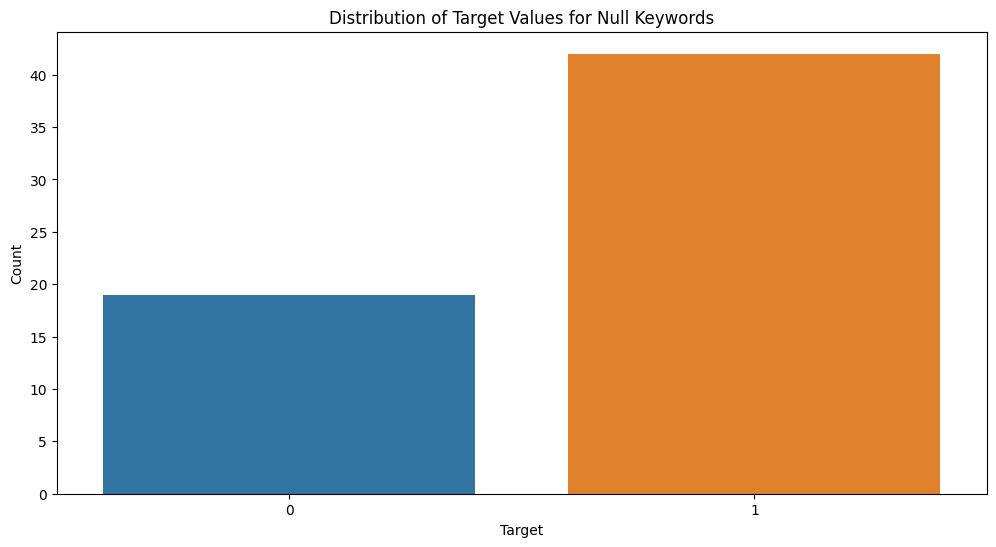

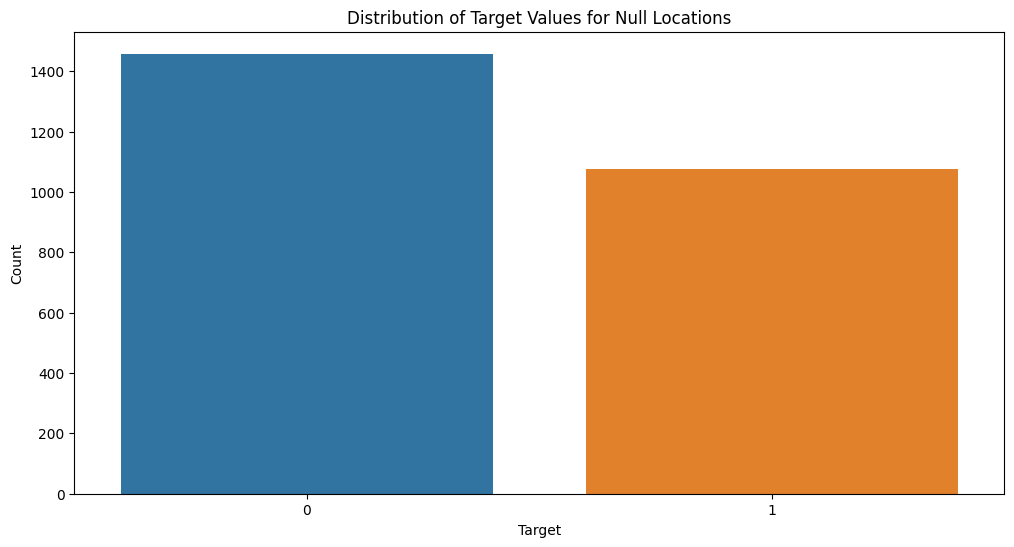

In [21]:
null_keywords = train_csv[train_csv['keyword'].isnull()]
null_location = train_csv[train_csv['location'].isnull()]

# Plot the distribution of target values for null keywords
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=null_keywords)
plt.title('Distribution of Target Values for Null Keywords')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Plot the distribution of target values for null locations
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=null_location)
plt.title('Distribution of Target Values for Null Locations')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

The lack of keywords actually indicate that the tweet is a disaster rather than isn't one. For the column, I'm going to remove this column since there are only a few null values.

For the location column, it is not a helpful predictor as it's somewhat balanced between being a disaster tweet and not being one. This will be dropped so we don't lose out on a third of the dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


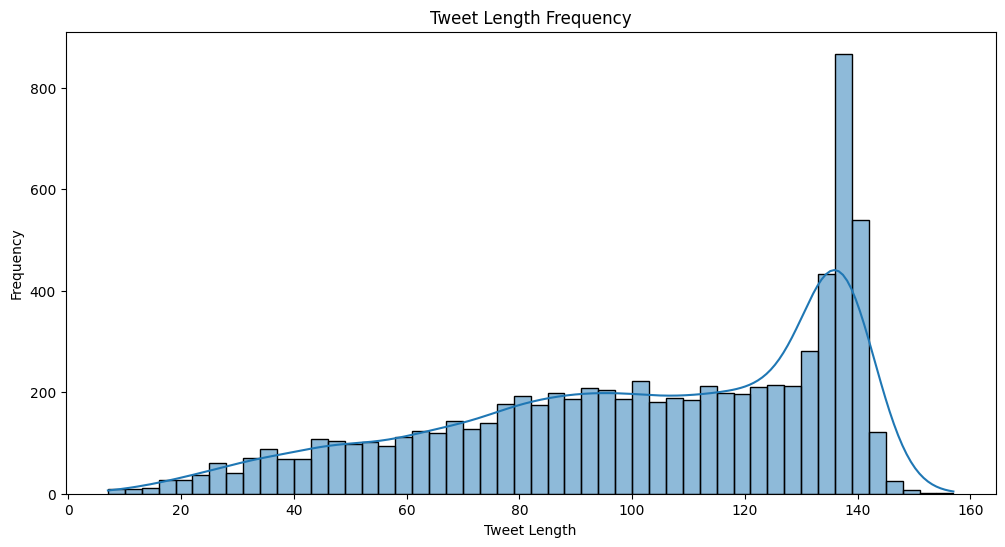

In [22]:
text_length = train_csv['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(text_length, bins=50, kde=True)
plt.title('Tweet Length Frequency')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing
To get the data ready to be trained on, a few things need to happen:
* Removing stopwords, excess whitespace, and non-alphanumeric characters from the text column
* Dropping the keyword and location columns
* Convert the text column to all lowercase
* Conduct stemming/lemmatization on the text column
* Tokenize the text column

In [23]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_and_process_text(df):
    # to lowercase
    df['training_text'] = df['text'].str.lower()

    # remove links
    df['training_text'] = df['training_text'].str.replace(r'http\S+|www\S+|https\S+', '', case=False)

    # remove punctuation
    df['training_text'] = df['training_text'].str.translate(str.maketrans('', '', string.punctuation))

    # remove non-alphanumeric chars
    df['training_text'] = df['training_text'].str.replace(r'\W', ' ', regex=True)

    # tokenize
    df['training_text'] = df['training_text'].apply(word_tokenize)

    # remove stopwords and lemmatize text
    df['training_text'] = df['training_text'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words if word not in stop_words])

    # Join words back to a single string
    df['training_text'] = df['training_text'].apply(lambda words: ' '.join(words))

clean_and_process_text(train_csv)
# Show difference before and after cleaning
print(train_csv['text'].head())
print(train_csv['training_text'].head())

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    13000 people receive wildfire evacuation order...
4    got sent photo ruby alaska smoke wildfire pour...
Name: training_text, dtype: object


In [24]:
# Drop the location and keyword columns
train_csv = train_csv.drop(['location', 'keyword'], axis=1)

## Word2Vec

Now that the text has been preprocessed, it can be fed into Word2Vec. As it names suggests, Word2Vec turns each word in the training corpus into a vector embedding to capture the context and semantics of each word. Behind the scenes, a small 2-layer neural network is training on all of the text that is outputting the probabilities of the next word that will follow. The weights of this network are used to create the word embeddings.

Source: https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673

In [25]:
# Tokenizer parameters
max_words = 1000  # maximum number of words to keep, based on word frequency
max_len = train_csv.training_text.map(len).max() // 2 # maximum length of all sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_csv['training_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(train_csv['training_text'])

X_padded = pad_sequences(sequences, maxlen=max_len)
X_train, X_val, y_train, y_val = train_test_split(X_padded, train_csv['target'], test_size=0.2, random_state=69)

# Tokenize the text for Word2Vec
tokenized_texts = [text.split() for text in train_csv['training_text']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=128, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_dim = 128
embedding_matrix = np.zeros((max_words, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = word2vec_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.zeros(embedding_dim)

# Model Architecture

I tested out 5 separate model architectures in this project. The first architecture is a basic architecture with two LSTM layers and dropout following after to try and help with overfitting. The second architecture used bidirectional LSTM layers with the same dropout to see if that would improve the performance. The third architecture is similar to the second, but has some additional additional dropout inside the layer to decrease overfitting. The fourth architecture adds normalization and dense layers to try to increase performance and overfitting. The fifth and final architecture is a return back to the first architecture but with 128 units instead of 64. These architecture's came about by testing what would produce the best results which is why the final one landed back on a more simplistic architecture. 

## Model 1 Architecture
Embedding(input_dim=embedding_matrix.shape[0], 
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix]),
    
LSTM(64, return_sequences=True),

Dropout(0.5),

LSTM(64),

Dropout(0.5),

Dense(1, activation='sigmoid')

## Model 2 Architecture
Embedding(input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            trainable=False),
            
Bidirectional(LSTM(64, return_sequences=True)),

Dropout(0.5),

Bidirectional(LSTM(64)),

Dropout(0.5),

Dense(1, activation='sigmoid')

## Model 3 Architecture
Embedding(input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            trainable=False),
            
Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)),

Dropout(0.5),

Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25,)),

Dropout(0.5),

Dense(1, activation='sigmoid')

## Model 4 Architecture
model.add(Embedding(
    input_dim=embedding_matrix.shape[0], 
    output_dim=embedding_matrix.shape[1], 
    weights=[embedding_matrix],
    trainable=False
))

model.add(Bidirectional(LSTM(
    max_len,
    return_sequences=True,
    recurrent_dropout=0.2
)))

model.add(Bidirectional(LSTM(
    max_len,
    return_sequences=True,
    recurrent_dropout=0.2
)))

model.add(GlobalMaxPool1D())

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(max_len, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(max_len, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


## Model 5 Architecture
Embedding(input_dim=embedding_matrix.shape[0], 
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix]),
    
LSTM(128, return_sequences=True),

Dropout(0.5),

LSTM(128),

Dropout(0.5),

Dense(1, activation='sigmoid')

In [26]:
# Define the LSTM model
first_model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix]),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Compile the model
first_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
first_model.summary()

# Train the model
first_model_history = first_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,000 (500.00 KB)

 Trainable params: 128,000 (500.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.6081 - loss: 0.6512 - val_accuracy: 0.7938 - val_loss: 0.4611
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8014 - loss: 0.4386 - val_accuracy: 0.7754 - val_loss: 0.4797
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.8332 - loss: 0.3806 - val_accuracy: 0.7859 - val_loss: 0.4744
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.8398 - loss: 0.3657 - val_accuracy: 0.7787 - val_loss: 0.5040
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.8533 - loss: 0.3447 - val_accuracy: 0.7800 - val_loss: 0.5083
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8597 - loss: 0.3401 - val_accuracy: 0.7866 - val_loss: 0.5033
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8503 - loss: 0.3470 - val_accuracy: 0.7814 - val_loss: 0.5427
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.8615 - loss: 0.3307 - val_accuracy: 0.7787

In [27]:
second_model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Compile the model
second_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
second_model.summary()

# Train the model
second_model_history = second_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,000 (500.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 128,000 (500.00 KB)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.5665 - loss: 0.6840 - val_accuracy: 0.5785 - val_loss: 0.6673
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5649 - loss: 0.6775 - val_accuracy: 0.5719 - val_loss: 0.6788
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.5559 - loss: 0.6839 - val_accuracy: 0.5942 - val_loss: 0.6668
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.6037 - loss: 0.6613 - val_accuracy: 0.6382 - val_loss: 0.6443
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.6457 - loss: 0.6418 - val_accuracy: 0.6448 - val_loss: 0.6283
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.6318 - loss: 0.6425 - val_accuracy: 0.6770 - val_loss: 0.6044
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.6681 - loss: 0.6112 - val_accuracy: 0.6717 - val_loss: 0.6075
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.6606 - loss: 0.6155 - val_accu

In [28]:
third_model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False),
    Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25,)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Compile the model
third_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
third_model.summary()

# Train the model
third_model_history = third_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,000 (500.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 128,000 (500.00 KB)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.5719 - loss: 0.6860 - val_accuracy: 0.5831 - val_loss: 0.6734
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.5625 - loss: 0.6804 - val_accuracy: 0.5863 - val_loss: 0.6659
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.5663 - loss: 0.6769 - val_accuracy: 0.6047 - val_loss: 0.6661
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.5742 - loss: 0.6749 - val_accuracy: 0.6041 - val_loss: 0.6642
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.5950 - loss: 0.6666 - val_accuracy: 0.6211 - val_loss: 0.6513
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.6064 - loss: 0.6596 - val_accuracy: 0.6586 - val_loss: 0.6344
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.6265 - loss: 0.6463 - val_accuracy: 0.6277 - val_loss: 0.6393
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.6323 - loss: 0.6419 - val_accu

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

fourth_model = Sequential()
fourth_model.add(Embedding(
    input_dim=embedding_matrix.shape[0], 
    output_dim=embedding_matrix.shape[1], 
    weights=[embedding_matrix],
    trainable=False
))
fourth_model.add(Bidirectional(LSTM(
    max_len,
    return_sequences=True,
    recurrent_dropout=0.2
)))
fourth_model.add(Bidirectional(LSTM(
    max_len,
    return_sequences=True,
    recurrent_dropout=0.2
)))
fourth_model.add(GlobalMaxPool1D())
fourth_model.add(BatchNormalization())
fourth_model.add(Dropout(0.5))
fourth_model.add(Dense(max_len, activation="relu"))
fourth_model.add(Dropout(0.5))
fourth_model.add(Dense(max_len, activation="relu"))
fourth_model.add(Dropout(0.5))
fourth_model.add(Dense(1, activation='sigmoid'))
fourth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fourth_model.summary()

# Train the model
fourth_model_history = fourth_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,000 (500.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 128,000 (500.00 KB)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - accuracy: 0.5407 - loss: 0.6920 - val_accuracy: 0.5850 - val_loss: 0.6868
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.5539 - loss: 0.6859 - val_accuracy: 0.5850 - val_loss: 0.6878
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.5737 - loss: 0.6797 - val_accuracy: 0.5850 - val_loss: 0.6848
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.5733 - loss: 0.6795 - val_accuracy: 0.6041 - val_loss: 0.6812
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.5999 - loss: 0.6661 - val_accuracy: 0.6474 - val_loss: 0.6483
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.6591 - loss: 0.6368 - val_accuracy: 0.6625 - val_loss: 0.6201
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.6640 - loss: 0.6147 - val_accuracy: 0.6395 - val_loss: 0.6469
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.6788 - loss: 0.6053 - val_accu

In [30]:
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=False,       
    verbose=1  
)

# Define the LSTM model
fifth_model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix]),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Compile the model
fifth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
fifth_model.summary()

# Train the model
fifth_model_history = fifth_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,000 (500.00 KB)

 Trainable params: 128,000 (500.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6222 - loss: 0.6440
Epoch 1: val_loss improved from inf to 0.46026, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 203ms/step - accuracy: 0.6229 - loss: 0.6433 - val_accuracy: 0.7859 - val_loss: 0.4603
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8148 - loss: 0.4115
Epoch 2: val_loss did not improve from 0.46026
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.8148 - loss: 0.4116 - val_accuracy: 0.7886 - val_loss: 0.4609
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8353 - loss: 0.3772
Epoch 3: val_loss did not improve from 0.46026
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.8352 - loss: 0.3773 - val_accuracy: 0.7879 - val_loss: 0.4665
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8437 - loss: 0.3710
Epoch 4: val_loss did not improve from 0.46026
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.8437 - loss: 0.3710 - va

# Results and Analysis


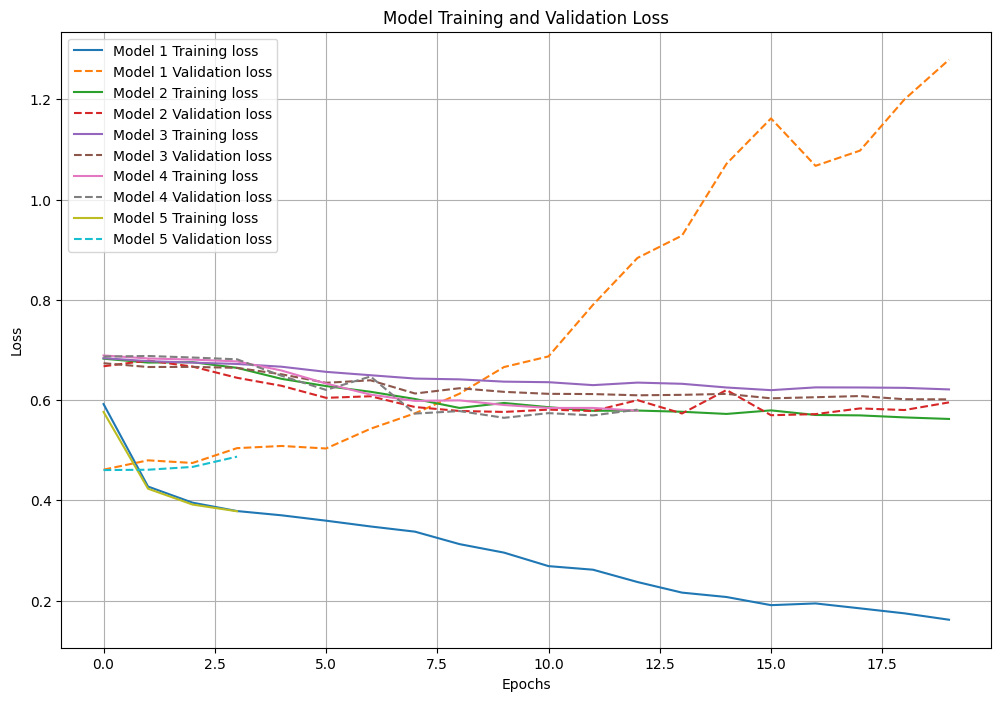

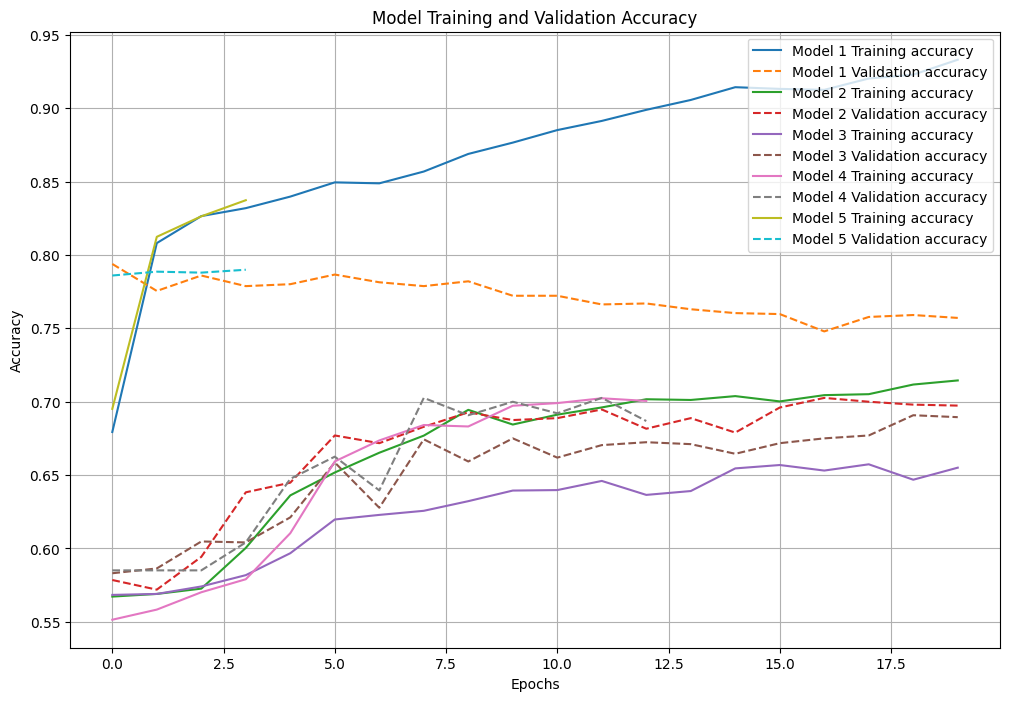

In [31]:
histories = [first_model_history, second_model_history, third_model_history, fourth_model_history, fifth_model_history]

def plot_metrics(histories, metric):
    plt.figure(figsize=(12, 8))
    
    for i, history in enumerate(histories):
        plt.plot(history.history[metric], label=f'Model {i+1} Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Model {i+1} Validation {metric}', linestyle='--')
    
    plt.title(f'Model Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

plot_metrics(histories, metric='loss')
plot_metrics(histories, metric='accuracy')

## Model Analysis

* Model 1 has great training accuracy, but starts to overfit.
* Model 2, 3, and 4 loss slowly improved, but started to plateau after a while.
* Model 5 which implemented early stopping, has the best training loss and accuracy. It would've lead to overfitting like model 1, but early stopping helped keep it in a strong position.

In [32]:
clean_and_process_text(test_csv)
print(test_csv['text'])
print(test_csv['training_text'])

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object
0                             happened terrible car crash
1       heard earthquake different city stay safe ever...
2       forest fire spot pond goose fleeing across str...
3                    apocalypse lighting spokane wildfire
4                   typhoon soudelor kill 28 china taiwan
                              ..

In [33]:
test_sequences = tokenizer.texts_to_sequences(test_csv['training_text'])
X_test_padded = pad_sequences(test_sequences, maxlen=max_len)

preds = fifth_model.predict(X_test_padded)
preds = np.round(preds).astype(int).reshape(-1)

submission = pd.DataFrame({'id': test_csv['id'], 'target': preds})

submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step


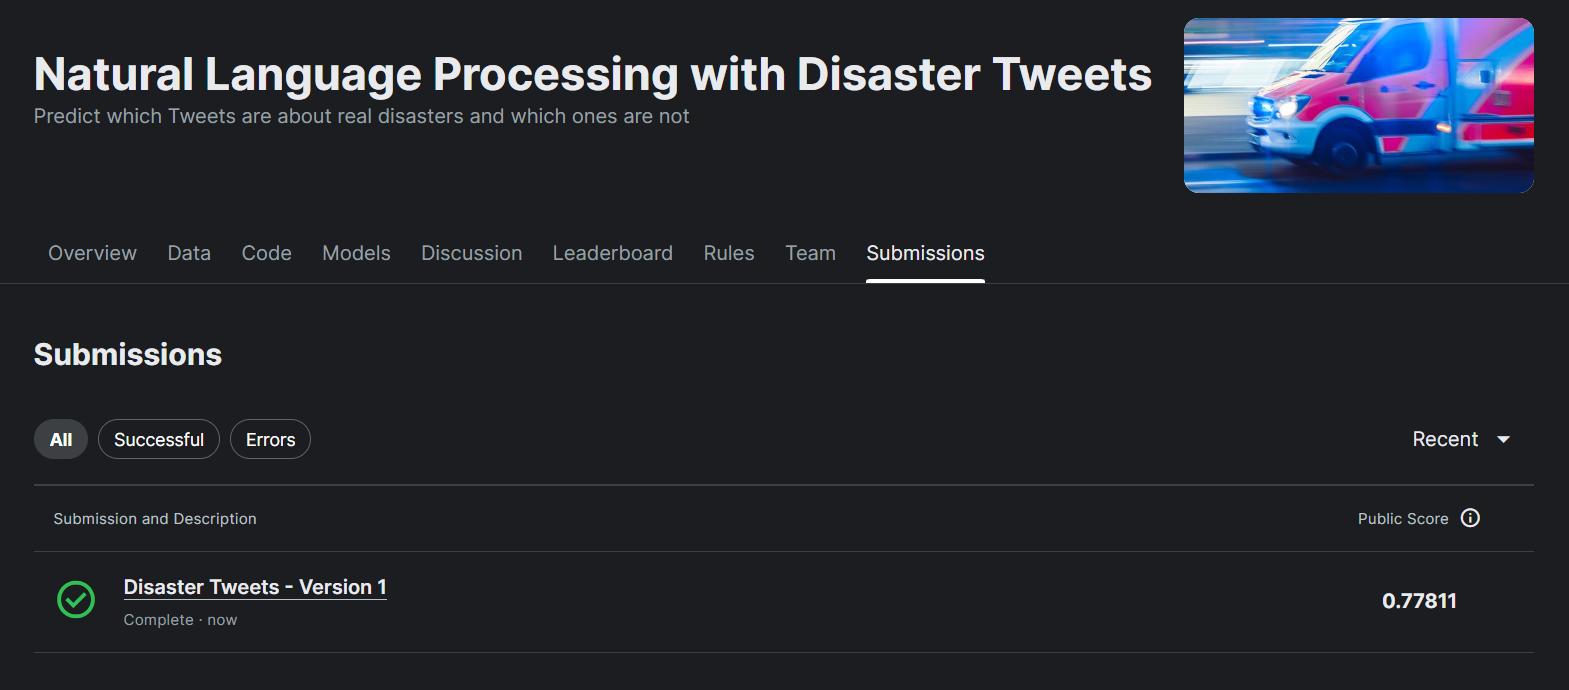

# Conclusion

More complex architectures didn't really help improve the performance. Ultimately, the most basic model had the best performance early on. It's typically better to use simpler models when possible, so I leaned into using Model 5 for the submission due to this reason.

I could try some other embeddings like GloVe or other architectures like transformers to modernize this project. There is probably some combination of the LSTM and Bidirectional models too that would lead to a better performance, but I couldn't make them work.